<a href="https://colab.research.google.com/github/olimpiarivera/ML-notebook/blob/main/03_Bias_Variance_Tradeoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias-Variance Dilemma

In this exercise session, we generate a synthetic dataset and examine the phenomenon
of bias/variance tradeoff in different models. After that, we will analyse some technique
to manage this tradeoff on real data. The presented procedures allow to decide
which model, among a set of given models, is best suited for the problem analysed.

## Bias-Variance Analysis

At first, let us generate a dataset, so that we have a ground-truth about the real model.
In this case, let us assume to have input $x \in [0, 5] $ and target:

\begin{equation}
t = t(x) = f(x) + \epsilon = 1 + \frac{1}{2}x + \frac{1}{10} x^{2} + \epsilon,
\end{equation}
where $\epsilon$ is a Gaussian random variable with $\mathbb{E}[\epsilon]=0$ and $Var(\epsilon) = \sigma ^2 = 0.7^{2}$.

In [1]:
import numpy as np
n_points = 1000
eps = 0.7

def fun(x):
  return 1 + 1/2 * x + 1/10 * x**2

x = np.random.uniform(low=0, high=5, size=(n_points, 1))

In [2]:
t = fun(x)
t_noisy = t + eps * np.random.randn(n_points, 1)

After that, we consider two different linear regression models:
\begin{align}
&L_1 : y(x) = a + bx \\
&L_2 : y(x) = a + bx + cx^2
\end{align}
If for the former one we do not need to make use of additional features, for the latter
one we need to define the basis functions $\phi_1(x_i) = x_i$ and $\phi_2(x_i)=x_i^{2}$

In [3]:
phi = np.concatenate([x, x**2], axis=1)

Once we generated the inputs for both the models, we train them:

In [4]:
from sklearn import linear_model
lin_model = linear_model.LinearRegression()
lin_model.fit(x, t_noisy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [5]:
qua_model = linear_model.LinearRegression()
qua_model.fit(phi, t_noisy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

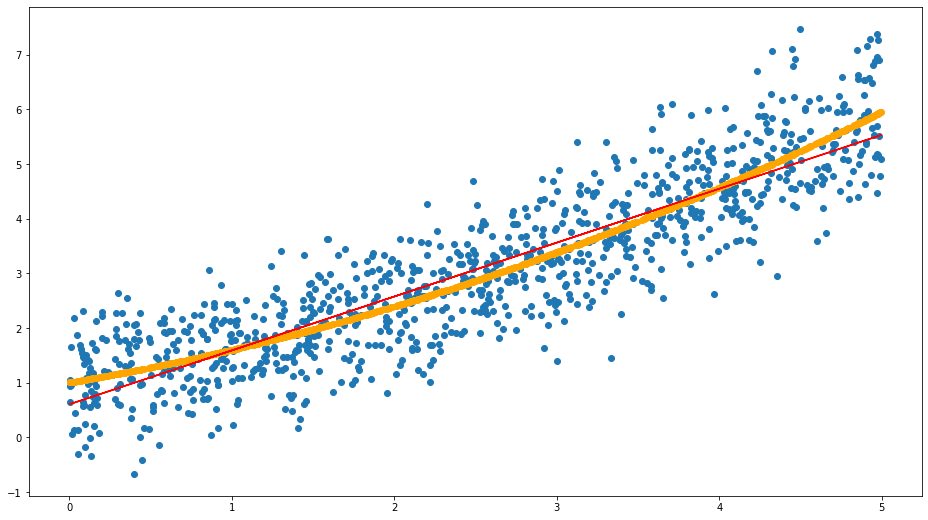

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.scatter(x, t_noisy, label='true') 

plt.plot(x, lin_model.predict(x), label='linear model', color='red')
plt.scatter(x, qua_model.predict(phi), label='quadratic model', color='orange')

plt.show()

Let us plot in the parameter space the models we estimated and the optimal ones, where
the optimal one in the family $L_1$ is the model that
$min_{a,b} \int_{0}^{5}(f(x) - a - bx)^{2}dx$:

In [7]:
# Real and best paramseters
real_par = np.array([1, 1/2, 1/10])
best_lin_par = np.array([7/12, 1, 0])

# Fitted parameters
lin_c = np.array([lin_model.intercept_[0], lin_model.coef_[0][0], 0])
qua_c = np.concatenate([qua_model.intercept_, qua_model.coef_.flatten()])

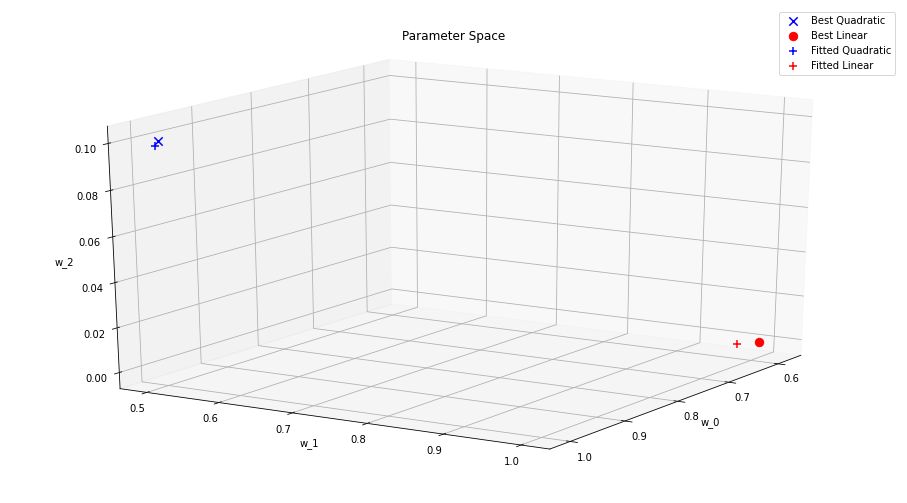

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
s = 70

ax.scatter(*real_par, marker='x', color='blue', s=s, label='Best Quadratic')
ax.scatter(*best_lin_par, marker='o', color='red', s=s, label='Best Linear')
ax.scatter(*qua_c, marker='+', color='blue', s=s, label='Fitted Quadratic')
ax.scatter(*lin_c, marker='+', color='red', s=s, label='Fitted Linear')

ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
ax.set_zlabel('w_2')
ax.view_init(elev=20., azim=32)
plt.title('Parameter Space')
plt.legend()
plt.grid()
plt.show()

As you can see, the parameters of the family $L_1$ lies in a 2D subspace, while the approximated quadratic models (i.e., those in $L_2$) may span over a 3D space. Hence, models from $L_2$ might coincide with the real model, i.e., $\text{real_par}$, while linear models coming from $L_1$ will always suffer from a bias which can not be reduced to zero.

If we want to compute the bias and variance of the two chosen models, we should
iterate the estimation procedure over multiple datasets.


In [10]:
# We write in a function the code we have seen above
def sample_and_fit(n_points):
  x = np.random.uniform(low=0, high=5, size=(n_points, 1))
  t = fun(x)
  t_noisy = t + eps * np.random.randn(n_points, 1)
  lin_model = linear_model.LinearRegression()
  lin_model.fit(x, t_noisy)
  phi = np.concatenate([x, x**2], axis=1)
  qua_model = linear_model.LinearRegression()
  qua_model.fit(phi, t_noisy)
  return lin_model, qua_model

# repeats the code above for n_repetition times, and saves the results
def multiple_sample_and_fit(n_repetitions, n_points):
  lin_coeff = np.zeros((n_repetitions, 3))
  qua_coeff = np.zeros((n_repetitions, 3))

  for i in range(n_repetitions):
    lin_model, qua_model = sample_and_fit(n_points)
    # Store the results
    lin_coeff[i, :] = np.concatenate([lin_model.intercept_, lin_model.coef_.flatten(), np.zeros(1)])
    qua_coeff[i, :] = np.concatenate([qua_model.intercept_, qua_model.coef_.flatten()])
  return lin_coeff, qua_coeff

# plot the models coefficients in a 3D space
def plot_models(lin_coeff, qua_coeff):
  fig = plt.figure(figsize=(16, 9))
  ax = fig.add_subplot(111, projection='3d')

  # (only these 2 lines have changed)
  ax.scatter(qua_coeff[:, 0], qua_coeff[:, 1], qua_coeff[:, 2], marker='.', color='blue', s=s, alpha=0.3)
  ax.scatter(lin_coeff[:, 0], lin_coeff[:, 1], lin_coeff[:, 2], marker='.', color='red', s=s, alpha=0.3)   
  
  ax.scatter(*real_par, marker='x', color='blue', s=100)
  ax.scatter(*best_lin_par, marker='o', color='red', s=100)
  ax.set_xlabel('w_0')
  ax.set_ylabel('w_1')
  ax.set_zlabel('w_2')
  ax.view_init(elev=20., azim=32)
  plt.title('Parameter Space')
  plt.grid()
  plt.show()

We sample, fit and plot the obtained models:

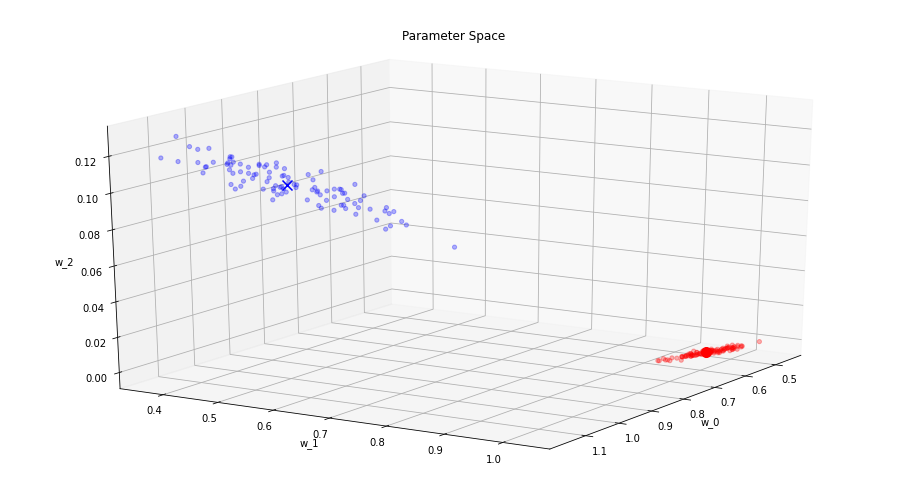

In [11]:
n_repetitions = 100
n_points = 1000
lin_coeff, qua_coeff = multiple_sample_and_fit(n_repetitions, n_points)
plot_models(lin_coeff, qua_coeff)

It is possible to see how the different trained models (represented as
crosses and x symbols) spread around the optimal parameters.

If we increase the number of repetitions, we just obtain more point in the cloud:

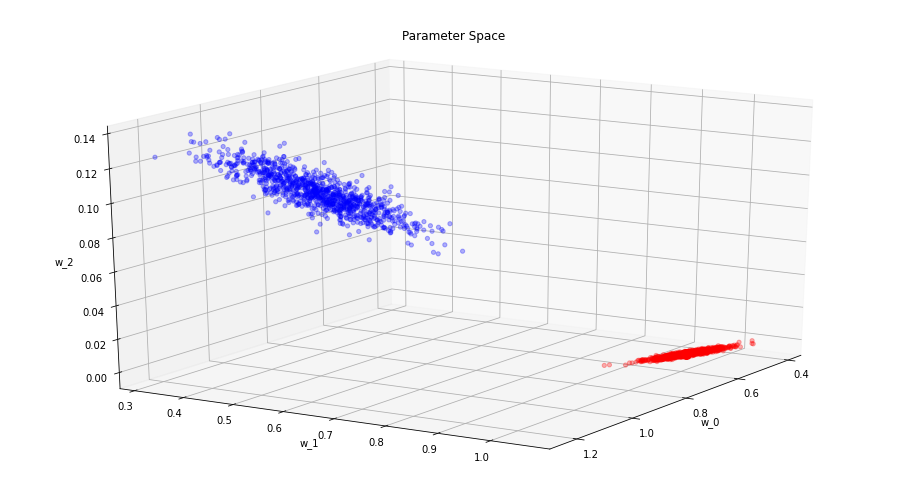

In [12]:
n_repetitions = 1000
n_points = 1000
lin_coeff, qua_coeff = multiple_sample_and_fit(n_repetitions, n_points)
plot_models(lin_coeff, qua_coeff)

On contrary, the more the points we consider for estimation $(N \rightarrow \infty)$, the more the resulting parameter vectors are close to the real and the best model in the hypothesis space, depending on the hypothesis space we choose. 

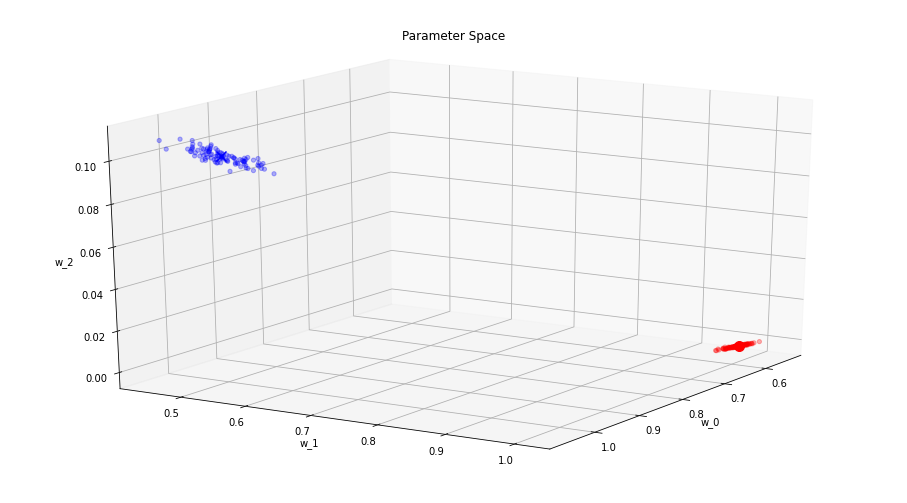

In [ ]:
n_repetitions = 100
n_points = 10000
lin_coeff, qua_coeff = multiple_sample_and_fit(n_repetitions, n_points)
plot_models(lin_coeff, qua_coeff)

Remember that even if we the estimated model coincides with the best model (e.g., by considering an infinite number of samples), we are not able to reduce the error on newly seen points to zero due to the irreducible error $\sigma^2$.

### Bias-Variance Decomposition
At last, we extract a *new point* and evaluate its bias and variance, by relying on the  **bias-variance decomposition**. 
By considering the expected square error on an **unseen sample** $x$, we obtain:
\begin{equation}
\mathbb{E}_{D}[(t(x) - y(x))^2] = \sigma^2 + Var_{D}[y(x)] + \mathbb{E}_{D}[f(x)-y(x)]^2,
\end{equation}

where we recall that f(x) is the real function generating the samples and the expectation is performed over the different realizations of the dataset.

In [13]:
n_points = 1
x_new = np.random.uniform(low=0, high=5, size=(n_points, 1))

# Compute target and add noise
t_new = fun(x_new)
t_new_noisy = t_new + eps * np.random.randn(n_points, 1)

# Compute features values
x_enh_new = np.array([1, x_new, 0])
phi_enh_new = np.array([1, x_new, x_new**2])

# Predict target using the two models
y_pred_lin = lin_coeff @ x_enh_new
y_pred_qua = qua_coeff @ phi_enh_new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


\begin{equation}
\mathbb{E}[(t(x) - y(x))^2]
\end{equation}

In [14]:
# we are taking the mean w.r.t. the different datatsets
error_lin = np.mean((t_new_noisy - y_pred_lin)**2) # square is inside here

\begin{equation}
 \mathbb{E}[f(x)-y(x)]^2
\end{equation}

In [15]:
bias_lin = np.mean(t_new - y_pred_lin)**2 # square is outside here

\begin{equation}
 Var[y(x)]
\end{equation}

In [16]:
variance_lin = np.var(y_pred_lin)

\begin{equation}
\sigma^2  = \mathbb{E}[(t(x) - y(x))^2] - Var[y(x)] - \mathbb{E}[f(x)-y(x)]^2,
\end{equation}

In [17]:
var_t_lin = error_lin - variance_lin - bias_lin

# we repeat the same formulas for the quadratic case
error_qua = np.mean((t_new_noisy - y_pred_qua)**2)
bias_qua = np.mean(t_new - y_pred_qua)**2
variance_qua = np.var(y_pred_qua)
var_t_qua = error_qua - variance_qua - bias_qua

print('---Single Point---')
print('Linear error: {}'.format(error_lin[0][0]))
print('Linear bias: {}'.format(bias_lin[0][0]))
print('Linear variance: {}'.format(variance_lin[0][0]))
print('Linear sigma: {} (unreliable)'.format(var_t_lin[0][0]))

print('---Single Point---')
print('Quadratic error: {}'.format(error_qua[0][0]))
print('Quadratic bias: {}'.format(bias_qua[0][0]))
print('Quadratic variance: {}'.format(variance_qua[0][0]))
print('Quadratic sigma: {} (unreliable)'.format(var_t_qua[0][0]))



---Single Point---
Linear error: 0.10368688627518995
Linear bias: 0.037578064345296515
Linear variance: 0.0015588188726081598
Linear sigma: 0.06455000305728528 (unreliable)
---Single Point---
Quadratic error: 0.01736770917589324
Quadratic bias: 4.527759014970745e-06
Quadratic variance: 0.0020916524526561563
Quadratic sigma: 0.015271528964222111 (unreliable)


In this case, the estimation of the variance $\sigma^2$ does not make sense since has been performed on a single sample.

Similarly, we can compute the bias and variance of the two models by integrating **over the entire input space** $[0, 5]$ and have a more stable estimate of the bias, variance, and irreducible error:

In [18]:
n_points = 101

x_new = np.linspace(0, 5, n_points)
t_new = fun(x_new)
t_new_noisy = t_new + eps * np.random.randn(n_points, 1).flatten()

x_enh_new = np.stack([np.ones(n_points), x_new, np.zeros(n_points)])
phi_enh_new = np.stack([np.ones(n_points), x_new, x_new**2])

y_pred_lin = lin_coeff @ x_enh_new
y_pred_qua = qua_coeff @ phi_enh_new

In [19]:
y_pred_lin.shape

(1000, 101)

In [20]:
# replicate the new points for each model
error_lin = np.mean((np.tile(t_new_noisy, (n_repetitions,1)) - y_pred_lin)**2)
bias_lin = np.mean(np.mean(np.tile(t_new, (n_repetitions,1)) - y_pred_lin, axis=0)**2) # I have to take the two means separately
variance_lin = np.mean(np.var(y_pred_lin, axis=0)) # same here
var_t_lin = error_lin - variance_lin - bias_lin

error_qua = np.mean((np.tile(t_new_noisy, (n_repetitions,1)) - y_pred_qua)**2)
bias_qua = np.mean(np.mean(np.tile(t_new, (n_repetitions,1)) - y_pred_qua, axis=0)**2)
variance_qua = np.mean(np.var(y_pred_qua, axis=0))
var_t_qua = error_qua - variance_qua - bias_qua

print('---All dataset---')
print('Linear error: {}'.format(error_lin))
print('Linear bias: {}'.format(bias_lin))
print('Linear variance: {}'.format(variance_lin))
print('Linear sigma: {}'.format(var_t_lin))

print('---All dataset--')
print('Quadratic error: {}'.format(error_qua))
print('Quadratic bias: {}'.format(bias_qua))
print('Quadratic variance: {}'.format(variance_qua))
print('Quadratic sigma: {}'.format(var_t_qua))

---All dataset---
Linear error: 0.623387271410699
Linear bias: 0.03612970404112383
Linear variance: 0.0010561235810676445
Linear sigma: 0.5862014437885076
---All dataset--
Quadratic error: 0.5635742732953601
Quadratic bias: 1.5465656078540652e-06
Quadratic variance: 0.0014887174349386722
Quadratic sigma: 0.5620840092948136


With this procedure we are able to check that the $L_2$ is generally able to reduce bias and variance sum, but it is not able to get a null irreducible error.


**Remark 1.** In real situations we do not know the real model generating data. Therefore, the analysis we conducted before is not a viable option. Nonetheless, the phenomena we analysed are still valid, since in real cases we will have a single point in the parameter space, which will be distributed according to the distribution induced by the model we selected

## Dealing with the Bias-Variance Tradeoff

In previous analysis, we made the assumption to know the real model, which is not an assumption
we can do in real scenarios. To deal with the bias/variance dilemma in *real scenarios* we use a set of techniques able to take into account the bias/variance tradeoff without having the necessity to know the *real* model. 

At first, we want to generate a new dataset:

In [21]:
n_tot = 40
eps = 2

def fun(x):
  return (0.5 - x) * (5 - x) * (x -3)

x = np.random.uniform(low=0, high=5, size=(n_tot, 1))
y = fun(x) + eps * np.random.randn(n_tot, 1)

We divide the dataset into:
- Training set $X_{train}$, i.e., the data we will use to learn the model parameters;
- Validation set $X_{vali}$, i.e., the data we will use to select the model;
- Test set $X_{test}$, i.e., the data we will use to test the performance of our model.

Usually, we use a split proportional to 50%/25%/25% for the three sets.

In [22]:
n_train = 20
n_vali = 10
n_test = 10

x_train, y_train = x[:n_train], y[:n_train]
x_vali, y_vali = x[n_train:n_train + n_vali], y[n_train:n_train + n_vali]
x_test, y_test = x[n_train + n_vali:], y[n_train + n_vali:]

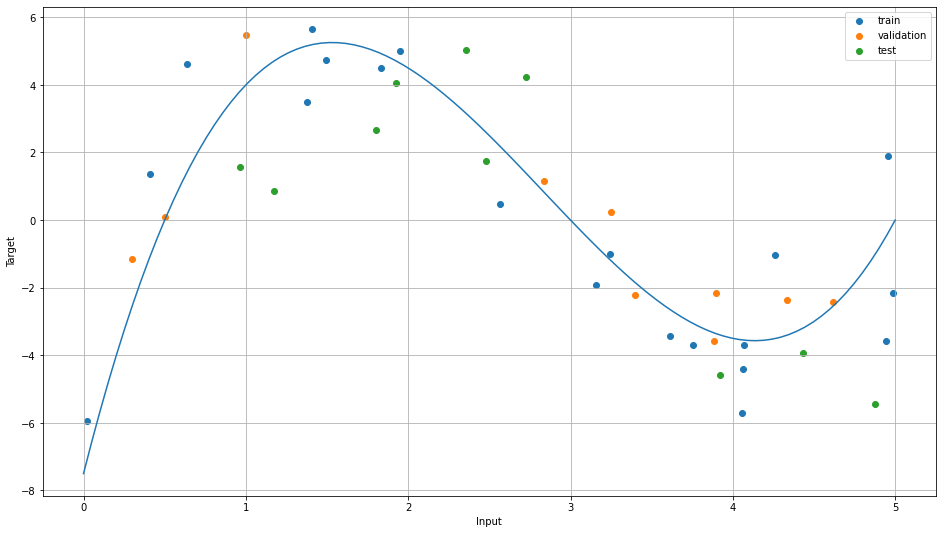

In [23]:
plt.figure(figsize=(16,9))
plt.scatter(x_train, y_train, label='train')
plt.scatter(x_vali, y_vali, label='validation')
plt.scatter(x_test, y_test, label='test')

plt.plot(np.linspace(0,5, 100), fun(np.linspace(0,5,100)))
plt.grid()
plt.legend()
plt.xlabel('Input')
plt.ylabel('Target')
plt.show()

Here we are not required to shuffle the data since we generate the input at random, but, in general, it is a good practice to randomly rearrange the data before splitting, since some ordering might be induced by those who provided you the data (e.g., enforced by some query on a database).
Here, we use:
- Hypothesis space: $y_n = f(x_n,w) = \sum_{k=0}^o x_n^k w_k$;
- Loss measure: $RSS(w) = \sum_n(y_n - t_n)^2$
- Optimization method: Least Square (LS) method;

and we want to select among polynomial models with order $o \in \{ 0, \dots, 9 \}$. If we compute the training error on different models we have:

In [24]:
# We employ this useful function from scikit-learn to produce polynomial features

from sklearn.preprocessing import PolynomialFeatures

degree = 3
poly = PolynomialFeatures(degree=degree)
x_train_tr = poly.fit_transform(x_train)
print(x_train_tr)

[[1.00000000e+00 2.56848445e+00 6.59711237e+00 1.69445806e+01]
 [1.00000000e+00 4.06472961e+00 1.65220268e+01 6.71575717e+01]
 [1.00000000e+00 4.98421336e+00 2.48423828e+01 1.23819736e+02]
 [1.00000000e+00 3.61369769e+00 1.30588110e+01 4.71905952e+01]
 [1.00000000e+00 1.40443419e+00 1.97243540e+00 2.77015572e+00]
 [1.00000000e+00 1.83236039e+00 3.35754459e+00 6.15223169e+00]
 [1.00000000e+00 2.44128869e-02 5.95989049e-04 1.45498133e-05]
 [1.00000000e+00 4.94374291e+00 2.44405940e+01 1.20828013e+02]
 [1.00000000e+00 4.09589674e-01 1.67763701e-01 6.87142797e-02]
 [1.00000000e+00 4.25713209e+00 1.81231736e+01 7.71527438e+01]
 [1.00000000e+00 4.95879387e+00 2.45896366e+01 1.21934939e+02]
 [1.00000000e+00 4.06725556e+00 1.65425678e+01 6.72828506e+01]
 [1.00000000e+00 6.37924450e-01 4.06947603e-01 2.59601826e-01]
 [1.00000000e+00 3.24500470e+00 1.05300555e+01 3.41700796e+01]
 [1.00000000e+00 3.15998923e+00 9.98553194e+00 3.15541734e+01]
 [1.00000000e+00 4.05861210e+00 1.64723321e+01 6.685480

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

models = [] # models are stored here
models_mse = [] # mse are stored here

for degree in range(0, 10):
  # fit a linear model for each of the selected polynomial orders
  lin_model = linear_model.LinearRegression()
  poly = PolynomialFeatures(degree=degree)
  x_train_tr = poly.fit_transform(x_train)
  lin_model.fit(x_train_tr, y_train)

  # measure model performance
  y_train_pred = lin_model.predict(x_train_tr)
  mse = mean_squared_error(y_train, y_train_pred)
  
  # store
  models.append(lin_model)
  models_mse.append(mse)

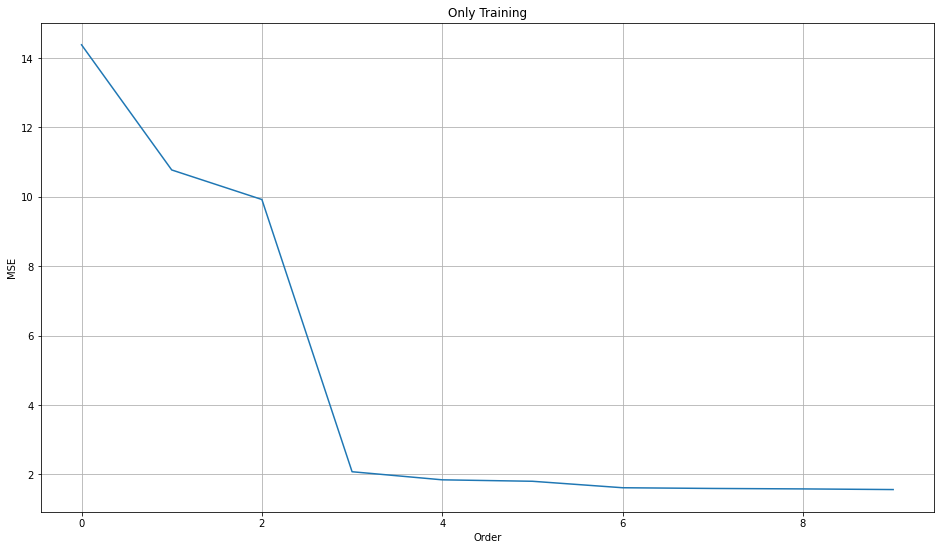

In [26]:
plt.figure(figsize=(16,9))
plt.plot(models_mse)
plt.title('Only Training')
plt.grid()
plt.xlabel('Order')
plt.ylabel('MSE')
plt.show()

We can see that this model does not equally perform on a test set:
with:

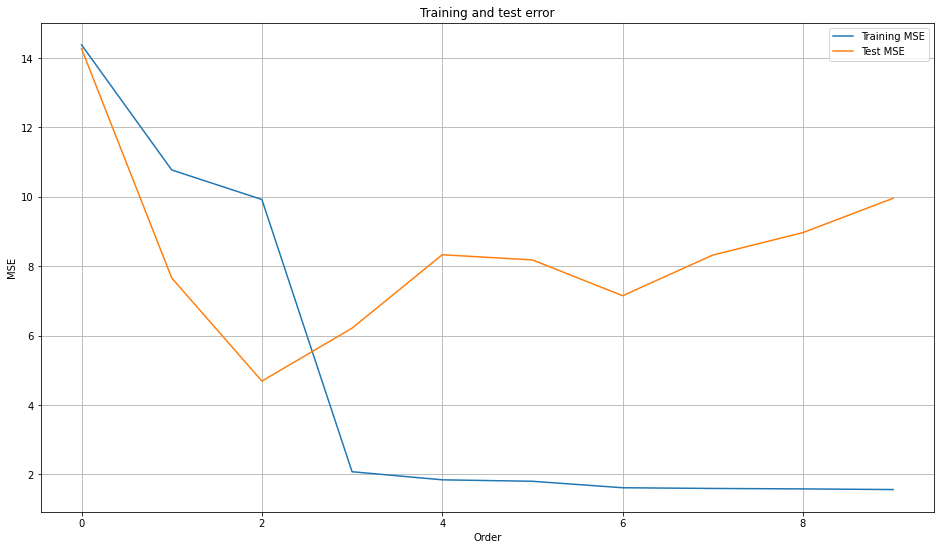

In [27]:
models_mse_test = []
for degree in range(0, 10):
  # load the fitted model
  lin_model = models[degree]
  
  # compute polynomial features for the test
  poly = PolynomialFeatures(degree=degree)
  x_test_tr = poly.fit_transform(x_test)

  # measure model performance on TEST
  y_test_pred = lin_model.predict(x_test_tr)
  mse = mean_squared_error(y_test, y_test_pred)
  models_mse_test.append(mse)

plt.figure(figsize=(16,9))
plt.plot(models_mse, label='Training MSE')
plt.plot(models_mse_test, label='Test MSE')
plt.title('Training and test error')
plt.grid()
plt.xlabel('Order')
plt.ylabel('MSE')
plt.legend()
plt.show()

To deal with this problem we will use a validation set and tune the order o of the polynomial on that set:

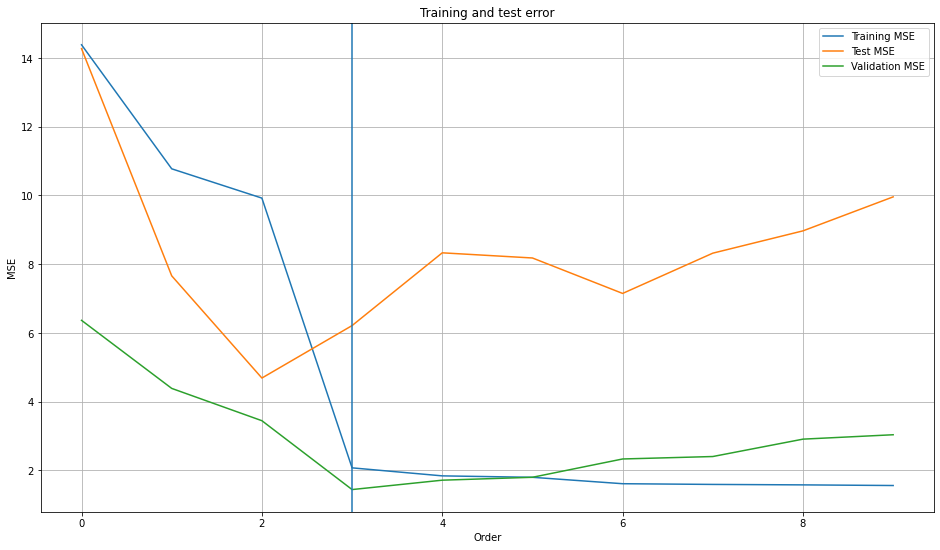

In [28]:
models_mse_vali = []
for degree in range(0, 10):
  # load the fitted model
  lin_model = models[degree]

  # compute polynomial features for the test  
  poly = PolynomialFeatures(degree=degree)
  x_vali_tr = poly.fit_transform(x_vali)
  y_vali_pred = lin_model.predict(x_vali_tr)

  # measure model performance on TEST
  mse = mean_squared_error(y_vali, y_vali_pred)
  models_mse_vali.append(mse)

plt.figure(figsize=(16,9))
plt.plot(models_mse, label='Training MSE')
plt.plot(models_mse_test, label='Test MSE')
plt.plot(models_mse_vali, label='Validation MSE')

best_model = np.argmin(models_mse_vali)
plt.axvline(best_model)
plt.title('Training and test error')
plt.grid()
plt.xlabel('Order')
plt.ylabel('MSE')
plt.legend()
plt.show()

However, the results of this procedure are strongly dependent on the validation set we used. Moreover, we are not using some of the samples during the training, which could improve the model accuracy. 

To better exploit the available data, we could resort to the use of **cross-validation**. This way, we have to join the Training and Validation set and divide it in k equally long partitions and use sequentially $k-1$ of them as training set and the remaining one as validation set. In the end, we average the results.

In [29]:
k_fold = 4 
n_cross = n_train + n_vali
x_cross, y_cross = x[:n_cross], y[:n_cross]
cross_indices = list(range(len(x_cross)))
MSE_cross = np.zeros(10)
for degree in range(10):
  # divide data
  for k in range(k_fold):
    start_vali = int(np.round(n_cross * k / k_fold)) # start of the validation fold
    end_vali = int(np.round(n_cross * (k+1) / k_fold)) # end of the validation fold

    vali_indices = list(range(int(start_vali), int(end_vali)))
    train_indices = [i for i in cross_indices if i not in vali_indices] # train on all the other indices

    x_fold_train = x_cross[train_indices]
    y_fold_train = y_cross[train_indices]

    x_fold_vali = x_cross[vali_indices]
    y_fold_vali = y_cross[vali_indices]

    # train a model with polynomial feature
    lin_model = linear_model.LinearRegression()
    poly = PolynomialFeatures(degree=degree)
    x_train_tr = poly.fit_transform(x_fold_train)
    x_vali_tr = poly.fit_transform(x_fold_vali)
    lin_model.fit(x_train_tr, y_fold_train)

    # measure cross_validation error
    y_vali_pred = lin_model.predict(x_vali_tr)
    MSE = mean_squared_error(y_fold_vali, y_vali_pred)
    MSE_cross[degree] += MSE 

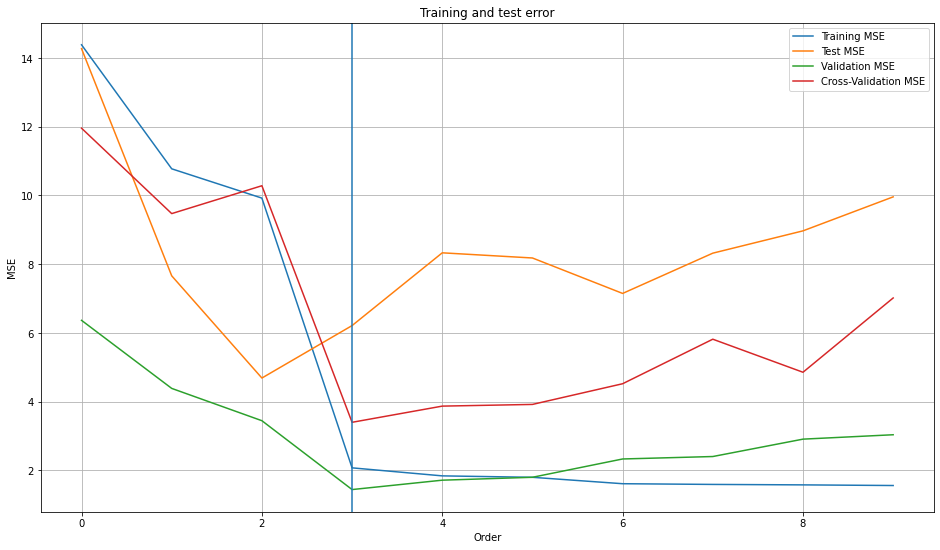

In [30]:
plt.figure(figsize=(16,9))
plt.plot(models_mse, label='Training MSE')
plt.plot(models_mse_test, label='Test MSE')
plt.plot(models_mse_vali, label='Validation MSE')
plt.plot(MSE_cross/k_fold, label='Cross-Validation MSE')

best_model = np.argmin(MSE_cross)
plt.axvline(best_model)
plt.title('Training and test error')
plt.grid()
plt.xlabel('Order')
plt.ylabel('MSE')
plt.legend()
plt.show()

The value of the error in the optimal point may be greater than the actual error we have on a test
set.
If we want to perform the Leave One Out (LOO), we just have to modify the number of folds we consider in the cross-validation procedure, i.e., $\text{k_fold}
= 30$. 

This kind of procedure is less biased than cross-validation, but requires more computational time.

# Homeworks

## Complexity-Adjusted Model Evaluation
Compute the $C_p$, $AIC$, $BIC$ and adjusted-$R2$ indexes for the dataset generated in the last part of the lecture (training + validation).

## Implementing Adaboost
Implement the AdaBoost meta-algorithm for linear regression and by using a weighted re-sampling technique to create each model on the data we considered in the last part of the lecture.

## Bootstrapping from generated data: Naive Bayes

Let's go back to the previous exercise session. Using Naive Bayes we know hot to generate new sample, thus we can arbitrarily enlarging our training set.

What happens if we train a new model with also the generated data?

Try to confirm your intuitions with this experiment:
- divide the dataset in train and test
- train a Naive Bayes model with the training part
- generate new samples with the generative model
- train another Naive Bayes model with the enlarged training set
- test both models on the training set
- compute bias, variance and irreducibile error, using the formula when needed